### Summarize Indeed Reviews
##### Lakkas Giannis

In [2]:
import pandas as pd
from langdetect import detect
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
from pathlib import Path
from fpdf import FPDF
from collections import defaultdict
import string
import re
from wordcloud import WordCloud

import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from nltk.tokenize import sent_tokenize, word_tokenize

import spacy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

D:\Anaconda\envs\data_science\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
D:\Anaconda\envs\data_science\lib\site-packages\spacy\language.py:1895: UserWarning: [W123] Argument disable with value ['parser', 'ner'] is used instead of ['senter'] as specified in the config. Be aware that this might affect other components in your pipeline.
  warnings.warn(


In [3]:
def clean_dataframe(df):
    #drop duplicates
    df.drop_duplicates(inplace=True)
    #drop na from dataframe
    df.dropna(inplace=True)
    #keep all rows that contain english in text field
    df_new = df[df.text.apply(detect).eq('en')]
    return df_new

In [4]:
def mdy_to_ymd(d):
    return datetime.strptime(d, '%B %d, %Y').strftime('%Y-%m-%d')

In [5]:
def fix_dates(df):
    df['date'] = df['date'].str.split(' - ').str[-1]
    df['date_formatted'] = (df['date'].str.replace('-', '').str.strip()).apply(mdy_to_ymd)
    df['date_formatted'] = pd.to_datetime(df['date_formatted'])
    df['rating_year'] = df['date_formatted'].dt.year
    df['rating_month'] = df['date_formatted'].dt.month
    return df

In [6]:
def plot_ratings_over_years(df):
    sns.lineplot(x='rating_year', y='rating', data=df, ci=None, palette=sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True), marker='D')
    #save the image in the folder, created by the scraper 
    plt.savefig('customer_analytics1/ratings_in_years.png')

In [7]:
def plot_ratings_former(df):
    df['former'] = df.description.str.contains('former', na=False, case=False)
    df_plot = df.groupby(['rating', 'former']).size().reset_index().pivot(columns='former', index='rating', values=0)
    sns.set_palette("Paired")
    df_plot.plot(kind='bar', stacked=True).set_title('Former/current employees’ ratings')
    plt.savefig('customer_analytics1/former.png')

In [8]:
def plot_ratings_per_job(df):
    #clean the job_description column
    df['job_description_cleaned'] = df['job_description'].str.replace('(Former Employee)','')\
    .str.replace('(Current Employee)','').str.replace("()","").str.replace("(","").str.strip()
    #find job role frequencies
    frequent_job_roles = df.groupby(['job_description_cleaned'], as_index=False)['rating'].count()
    #find the jobs with more than 100 ratings 
    jobs_with_most_ratings = list(frequent_job_roles[frequent_job_roles['rating'] > 100]['job_description_cleaned'])
    # for small companies, set the threshold to 30
    if not jobs_with_most_ratings:
        jobs_with_most_ratings = list(frequent_job_roles[frequent_job_roles['rating'] > 30]['job_description_cleaned'])
        # for smaller, set the thershold to 3
        if not jobs_with_most_ratings:
            jobs_with_most_ratings = list(frequent_job_roles[frequent_job_roles['rating'] > 3]['job_description_cleaned'])
    #plot
    f, ax = plt.subplots(figsize=(6, 12))
    #keep the jobs with more than 100 ratings 
    per_job_df = df[df['job_description_cleaned'].isin(jobs_with_most_ratings)]
    # group by and sort them in descending order
    per_job_df = per_job_df.groupby("job_description_cleaned", as_index=False).rating.mean().sort_values(by='rating',ascending=False)
    # create the barplots
    try:
        sns.barplot(x=per_job_df['rating'], y=per_job_df['job_description_cleaned'], data=per_job_df,
                label="Total", color="skyblue").set(title='Average rating value for job roles with the more ratings')
        sns.despine(left=True, bottom=True)
        # save the plot to the specific folder
        plt.savefig('customer_analytics1/ratings_roles.png', bbox_inches = "tight")
    except:
        print("No data, to create ratings per roles")

In [9]:
def plot_ratings_per_region(df):
    # find the regions with more than 250 ratings 
    frequent_job_regions = df.groupby(['country'], as_index=False)['rating'].count()
    regions_with_most_ratings = list(frequent_job_regions[frequent_job_regions['rating'] > 250]['country'])
    # for small companies, set the threshold to 30
    if not regions_with_most_ratings:
        regions_with_most_ratings = list(frequent_job_regions[frequent_job_regions['rating'] > 30]['country'])
        # for small companies, set the threshold to 3
        if not regions_with_most_ratings:
            regions_with_most_ratings = list(frequent_job_regions[frequent_job_regions['rating'] > 3]['country']) 
    #plot 
    f, ax = plt.subplots(figsize=(6, 12))
    #keep the regions with more than 250 ratings 
    per_region_df = df[df['country'].isin(regions_with_most_ratings)]
    ## group by and sort them in descending order
    per_region_df = per_region_df.groupby("country",as_index=False).rating.mean().sort_values(by='rating',ascending=False)
    # create the barplots
    try:
        sns.barplot(x=per_region_df['rating'], y=per_region_df['country'], data=per_region_df,
            label="Total", color="skyblue").set(title='Average rating value for regions with the more ratings')
        sns.despine(left=True, bottom=True)
        # save the plot
        plt.savefig('customer_analytics1/ratings_regions.png', bbox_inches = "tight")
    except:
        print("No data, to create ratings per regions")

In [10]:
def plot_ratings_for_remote_jobs(df):
    # keep the rows which contain the word "remote" in country column
    df_remote = df[df.country.str.contains('remote', na=False, case=False)]
    plt.figure(figsize=(6,4))
    sns.countplot(x='rating', hue='former', data=df_remote)

In [11]:
def plot_word_clouds(x, sent):
    #select background color 
    color = 'white' if sent == 'pos' else 'black'
    fig, axes = plt.subplots(1, 2, figsize=(20, 20))
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()
    # find all words frequencies
    fdist = FreqDist(all_words)
    # create the wordcloud from these frequencies
    try:
        wordcloud = WordCloud(background_color=color, colormap='Blues', mode="RGBA", max_words=1000)
        wordcloud.generate_from_frequencies(frequencies=fdist)
        
        axes[0].imshow(wordcloud, interpolation="bilinear")
        axes[0].axis("off")
        # find all bigrams and their frequencies
        bigrams_df = (pd.Series(nltk.ngrams(all_words, 2)).value_counts())
        bigrams_df = bigrams_df.to_frame()
        bigrams_df.reset_index(inplace=True)
        bigrams_df["index"] = bigrams_df["index"].agg(' '.join)
        # create the wordcloud from the bigram's frequencies
        wordcloud.generate_from_frequencies(frequencies=dict(bigrams_df.values))
        axes[1].imshow(wordcloud, interpolation="bilinear")
        axes[1].axis("off")
        # save the plot
        plt.savefig('customer_analytics1/wordclouds'+'_'+sent+'.png', bbox_inches = "tight")
    except:
        print("No data to create wordnets")

In [12]:
def remove_stopwords(rev):
    # remove punctuation and stop words from the text
    rev_new = " ".join([i.translate((str.maketrans('', '', string.punctuation))) for i in rev if i not in stop_words])
    return rev_new

In [13]:
def lemmatization(texts, tags=['NOUN', 'ADJ']): 
    # filter noun and adjective
    output = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        # keep the lemmas
        output.append([token.lemma_ for token in doc if token.pos_ in tags])
    return output

In [14]:
def clean_text(df):
    # remove short words (length < 3)
    df['text_clean'] = df['text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))
    # remove stopwords from the text
    reviews = [remove_stopwords(r.split()) for r in df['text_clean']]
    # make entire text lowercase
    reviews = [r.lower() for r in reviews]
    # split the text into words
    tokenized_reviews = pd.Series(reviews).apply(lambda x: x.split())
    # lemmatize 
    reviews_2 = lemmatization(tokenized_reviews)
    reviews_3 = []
    for i in range(len(reviews_2)):
        reviews_3.append(' '.join(reviews_2[i]))
        
    df['reviews'] = reviews_3
    return df

In [15]:
class PDF(FPDF):
    def __init__(self, company, folder):   
        super().__init__()
        self.WIDTH = 210
        self.HEIGHT = 297
        # the company's name
        self.company_name = company
        # the folder with plots
        self.folder = folder
        self.set_auto_page_break(auto= False)
        
          
    def header(self):
        # Custom logo and positioning
        # Create an `assets` folder and put any wide and short image inside
        # Name the image `logo.png`
        self.image('customer_analytics1\\'+ self.company_name +'.jpg', x=97.5, y=12, w=15, h=12.5)
        self.set_font('Arial', 'B', 11)
        self.cell(self.WIDTH - 80)
        self.cell(60, 1, self.company_name + " Report", 0, 0, 'R')
        self.ln(20)
        
    def footer(self):
        # Page numbers in the footer
        self.set_y(-15)
        self.set_font('Arial', 'I', 8)
        self.set_text_color(128)

    def page_body(self, images):
        self.set_text_color(r= 70, g = 130, b = 180)
        #first title
        self.cell(w=30, h=-15, txt="At a glance",ln=1, align="L")
        #ratings over years plot
        r = re.compile(".*ratings_in_years")
        try:
            basic0 = list(filter(r.match, images))[0]
            self.image(basic0, x=15, y=25, w=95, h=50)
        except:
            print("The plot does not exist")
        
        # former employees plot
        r = re.compile(".*former")
        self.cell(w=190, h=15, txt="Former Employees",ln=1, align="R")
        try:
            former0 = list(filter(r.match, images))[0]
            self.image(former0, 110, y=25, w=95, h=50)
        except:
            print("The plot does not exist")

        # per job roles plot
        self.cell(w=190, h=110, txt="Per Job Roles",ln=1, align="R")
        r = re.compile(".*ratings_roles")
        try:
            job0 = list(filter(r.match, images))[0]
            self.image(job0, x=110, y=90, w=95, h=90)
        except:
            print("The plot does not exist")
        
        # per region plot
        self.cell(w=30, h=-110, txt="Per Region",ln=1, align="L")
        r = re.compile(".*ratings_region")
        try:
            region0 = list(filter(r.match, images))[0]
            self.image(region0, x=10, y=90, w=95, h=90)
        except:
            print("The plot does not exist")
            
        # wordcloud for positive reviews
        self.cell(w=200, h=310, txt="Most frequent words/bigrams in Positive Reviews",ln=1, align="C")
        r = re.compile(".*wordclouds_pos")
        try:
            wc_p0 = list(filter(r.match, images))[0]
            self.image(wc_p0, x=20, y=190, w=180, h=45)
        except:
            print("The plot does not exist")
        
        # wordcloud for negative reviews
        r = re.compile(".*wordclouds_neg")
        try:
            wc_n0 = list(filter(r.match, images))[0]
            self.image(wc_n0, x=20, y=245, w=180, h=45)
        except:
            print("The plot does not exist")
        self.cell(w=200, h=-200, txt="Most frequent words/bigrams in Negative Reviews", ln=1, align="C")

    def print_page(self):
        # Generates the report
        images = [str(child.resolve()) for child in Path.iterdir(Path(self.folder)) if str(child).endswith('.png') ]
        self.add_page()
        self.page_body(images)

In [16]:
def summarize(path: str):
    df = pd.read_csv(path)
    # chech if there aren' t data and print the message
    if df.empty:
        print("The report cannot be produced because there are not data for this company")
        return 0
    #extract company's name from filename
    company = path.split('_')[0].upper()
    df = clean_dataframe(df)
    # split the complex field description job to 3 parts :  description - country - date
    df[['job_description', 'country+date']] = df.description.str.split("[)] - ", 1, expand=True)
    df[['country', 'date']] = df["country+date"].str.split(" - ", 1, expand=True)
    # again drop nas
    df.dropna(inplace=True)
    df = fix_dates(df)
    #save the ratings over years plot
    plot_ratings_over_years(df)
    #save the ratings for former/current employees plot
    plot_ratings_former(df)
    #save the ratings per job
    plot_ratings_per_job(df)
    #save the ratings per region
    plot_ratings_per_region(df)
    #save the ratings for the remote positions
    plot_ratings_for_remote_jobs(df)
    
    # keep the rows with rating equal to 5(good reviews) and with big texts(with more than 500 words(tokens))
    df_good = df[(df['rating'] == 5) & (len(df['text'].str.split()) >= 500)]
    # clean the text 
    df_good_c = clean_text(df_good)
    # plot the word_clouds, the 'pos' param means that the reviews are positive and so the background will be white
    plot_word_clouds(df_good_c['reviews'], 'pos')
    
    # keep the rows with rating equal to 1(bad reviews) and with big texts(with more than 500 words(tokens))
    df_bad = df[(df['rating'] == 1) & (len(df['text'].str.split()) >= 500)]
    # clean the text 
    df_bad_c = clean_text(df_bad)
    # plot the word_clouds, the 'neg' param means that the reviews are negative and so the background will be black
    plot_word_clouds(df_bad_c['reviews'], 'neg')
    
    
    # pdf creation 
    pdf = PDF(company=company, folder='customer_analytics1')
    # create the first page
    pdf.print_page()
    # save the pdf with format "<company_name>.pdf"
    pdf.output(company + '.pdf', 'F')

C:\Users\giann\AppData\Local\Temp\ipykernel_15580\2459520242.py:11: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  df[['job_description', 'country+date']] = df.description.str.split("[)] - ", 1, expand=True)
C:\Users\giann\AppData\Local\Temp\ipykernel_15580\2459520242.py:12: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  df[['country', 'date']] = df["country+date"].str.split(" - ", 1, expand=True)
C:\Users\giann\AppData\Local\Temp\ipykernel_15580\784224055.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='rating_year', y='rating', data=df, ci=None, palette=sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True), marker='D')
C:\Users\giann\AppData\Local\Temp\ipykernel_15580\784224055.py:2: UserWarning: Ignoring `palette` because no `hue` variable 

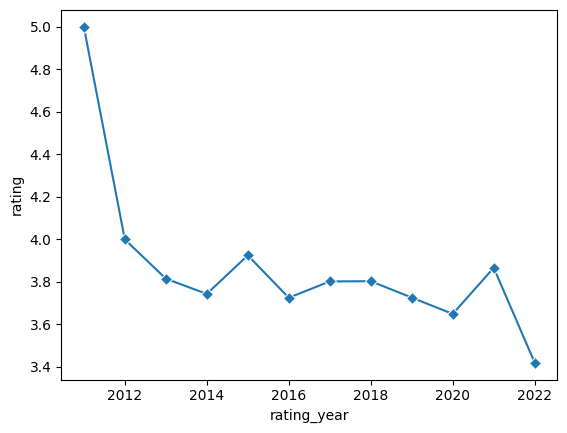

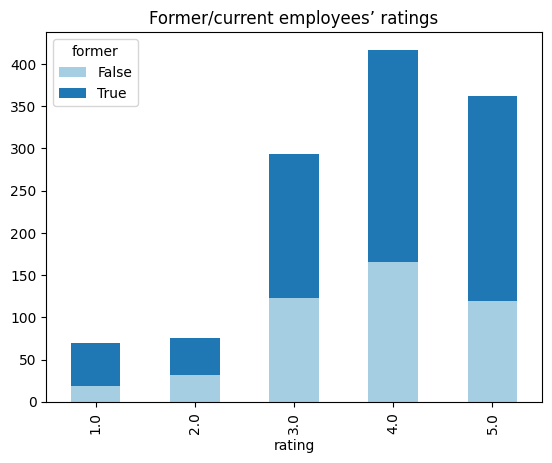

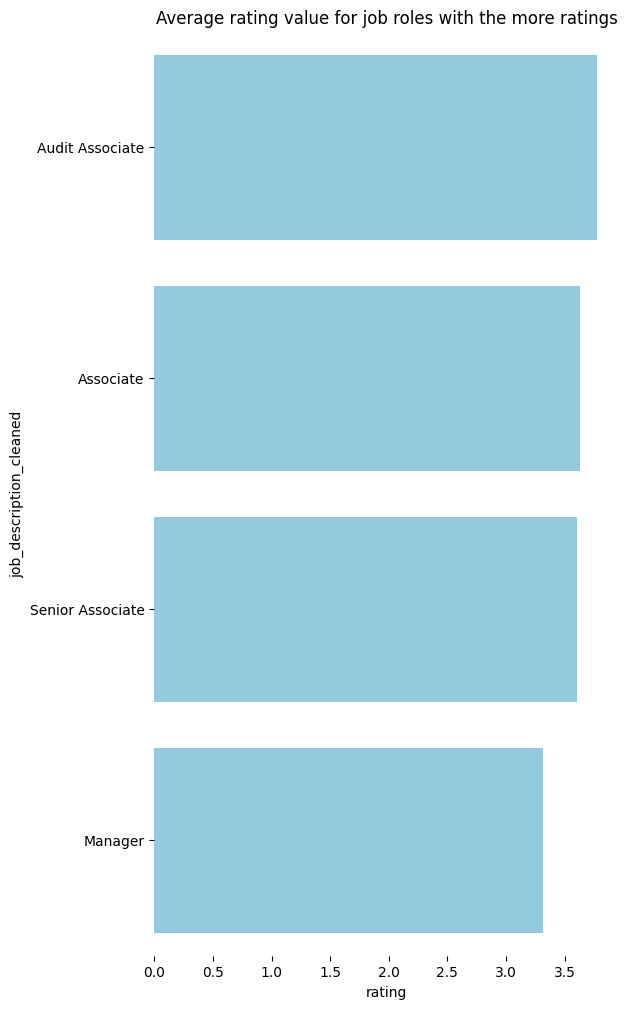

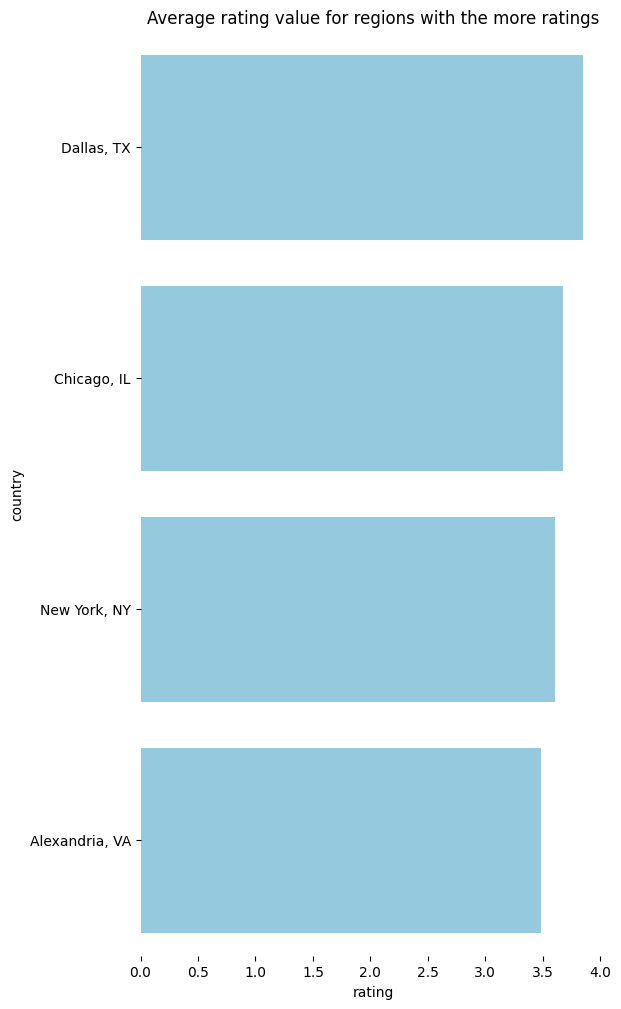

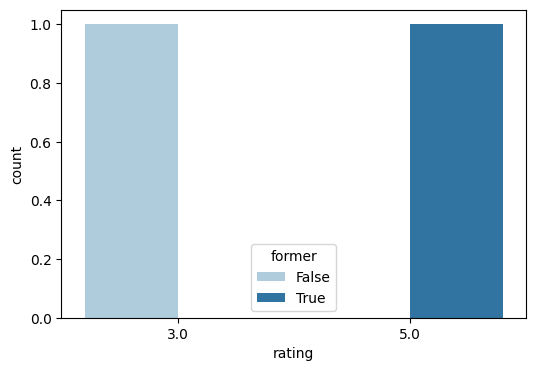

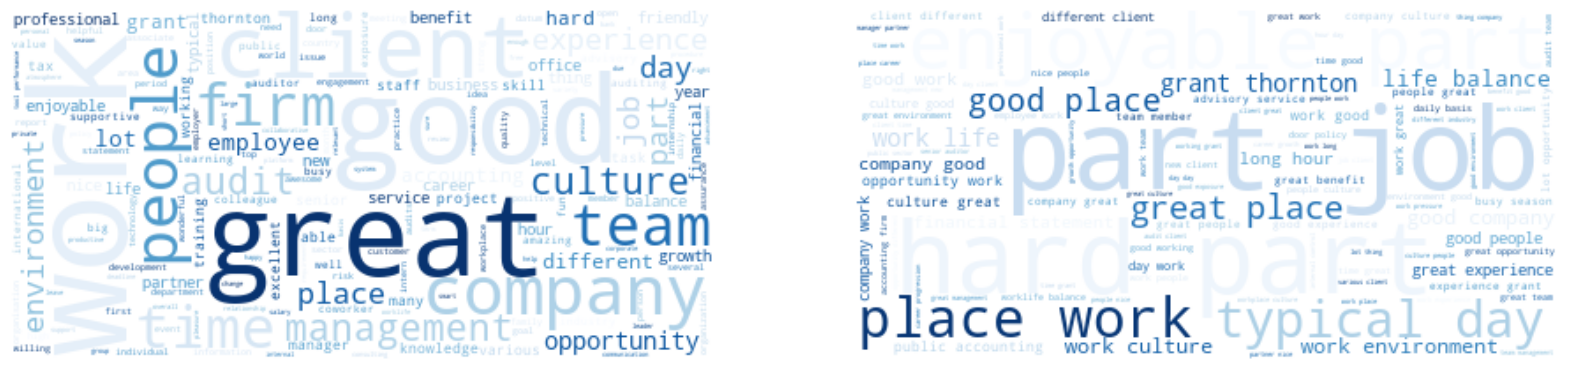

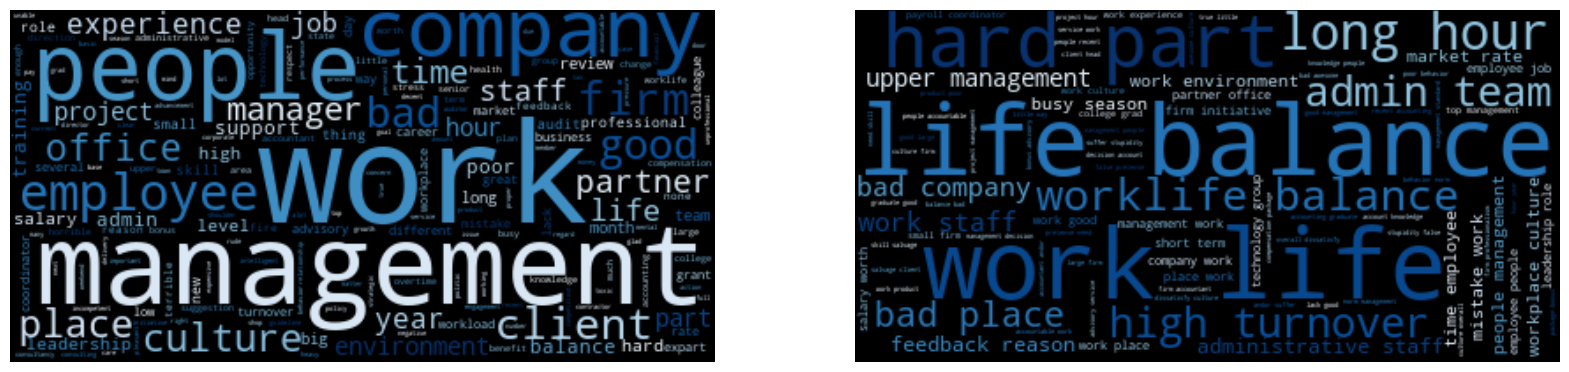

In [17]:
summarize(path='Grant Thornton_data.csv')